# Planification de la production d'électricité

## 1. Modèle de base des centrales thermiques

### 1.1 Planification journalière du parc thermique

In [1]:
import gurobipy as gp

ModuleNotFoundError: No module named 'gurobipy'

In [3]:
Dem=[15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]
for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
CENTRALE, nb, Pmin, Pmax, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 1.5],
    'B' : [10, 1250, 1750, 1.38],
    'C' : [5, 1500, 4000, 2.750],
})

model = gp.Model(name = 'Centrales thermiques')

NBcentrale = {(i,j) : model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

CSTR1 = { (i,j) : model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

model.setObjective(sum(Puiss[i,j]*Cmwh[i] for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

model.update()

model.optimize()

Restricted license - for non-production use only - expires 2023-10-25
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 240 rows, 144 columns and 432 nonzeros
Model fingerprint: 0xbaa479b0
Variable types: 72 continuous, 72 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 3e+00]
  Bounds range     [5e+00, 1e+01]
  RHS range        [5e+00, 4e+04]
Found heuristic solution: objective 1234360.0000
Presolve removed 234 rows and 139 columns
Presolve time: 0.01s
Presolved: 6 rows, 5 columns, 14 nonzeros
Found heuristic solution: objective 869400.00000
Variable types: 2 continuous, 3 integer (0 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 4 (of 4 available processors)

Solution count 2: 869400 1.23436e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.694000000000e+05, 

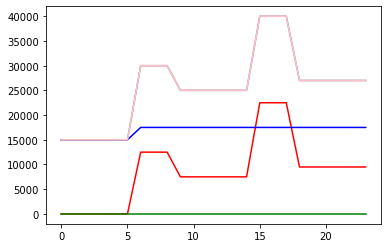

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PA=[]; PB=[]; PC=[]; PTOT=[]
NBA=[]; NBB=[]; NBC=[]



for j in range(len(Dem)):        
    PA.append(Puiss["A",j].x)
    PB.append(Puiss["B",j].x)
    PC.append(Puiss["C",j].x)
    PTOT.append(Puiss["A",j].x + Puiss["B",j].x + Puiss["C",j].x)
    
ar = [PA, PB, PC, PTOT]

df=pd.DataFrame(data=ar, index=["A", "B", "C", "TOT"])

plt.plot(df.loc["A"],'r')
plt.plot(df.loc["B"],'b')
plt.plot(df.loc["C"],'g')
plt.plot(Dem,'grey')
plt.plot(df.loc["TOT"],'pink')



plt.show()

In [43]:
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
A,0.0,0.0,0.0,0.0,0.0,0.0,12500.0,12500.0,12500.0,7500.0,...,7500.0,22500.0,22500.0,22500.0,9500.0,9500.0,9500.0,9500.0,9500.0,9500.0
B,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,17500.0,17500.0,17500.0,17500.0,...,17500.0,17500.0,17500.0,17500.0,17500.0,17500.0,17500.0,17500.0,17500.0,17500.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TOT,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,30000.0,30000.0,30000.0,25000.0,...,25000.0,40000.0,40000.0,40000.0,27000.0,27000.0,27000.0,27000.0,27000.0,27000.0


In [44]:
model.relax()
model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 240 rows, 144 columns and 432 nonzeros
Model fingerprint: 0xbaa479b0
Variable types: 72 continuous, 72 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 3e+00]
  Bounds range     [5e+00, 1e+01]
  RHS range        [5e+00, 4e+04]
Presolved: 6 rows, 5 columns, 14 nonzeros

Continuing optimization...


Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 4 (of 4 available processors)

Solution count 2: 869400 1.23436e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.694000000000e+05, best bound 8.694000000000e+05, gap 0.0000%


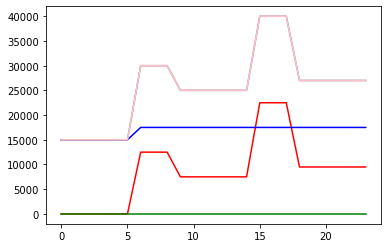

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PA=[]; PB=[]; PC=[]; PTOT=[]
NBA=[]; NBB=[]; NBC=[]



for j in range(len(Dem)):        
    PA.append(Puiss["A",j].x)
    PB.append(Puiss["B",j].x)
    PC.append(Puiss["C",j].x)
    PTOT.append(Puiss["A",j].x + Puiss["B",j].x + Puiss["C",j].x)
    
ar = [PA, PB, PC, PTOT]

df=pd.DataFrame(data=ar, index=["A", "B", "C", "TOT"])

plt.plot(df.loc["A"],'r')
plt.plot(df.loc["B"],'b')
plt.plot(df.loc["C"],'g')
plt.plot(Dem,'grey')
plt.plot(df.loc["TOT"],'pink')



plt.show()

In [46]:
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
A,0.0,0.0,0.0,0.0,0.0,0.0,12500.0,12500.0,12500.0,7500.0,...,7500.0,22500.0,22500.0,22500.0,9500.0,9500.0,9500.0,9500.0,9500.0,9500.0
B,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,17500.0,17500.0,17500.0,17500.0,...,17500.0,17500.0,17500.0,17500.0,17500.0,17500.0,17500.0,17500.0,17500.0,17500.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TOT,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,30000.0,30000.0,30000.0,25000.0,...,25000.0,40000.0,40000.0,40000.0,27000.0,27000.0,27000.0,27000.0,27000.0,27000.0


In [28]:
for j in range(len(Dem)):
    print(CSTR3[j].slack)
    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [35]:
for i in CENTRALE:
    for j in range(len(Dem)):
        print(CSTR2[i,j].slack)

0.0
0.0
0.0
0.0
0.0
0.0
-11500.0
-11500.0
-11500.0
-500.0
-500.0
-500.0
-500.0
-500.0
-500.0
-1500.0
-1500.0
-1500.0
-500.0
-500.0
-500.0
-500.0
-500.0
-500.0
-750.0
-750.0
-750.0
-750.0
-750.0
-750.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [36]:
for i in CENTRALE:
    for j in range(len(Dem)):
        print(CSTR1[i,j].slack)

0.0
0.0
0.0
0.0
0.0
0.0
2300.0
2300.0
2300.0
4100.0
4100.0
4100.0
4100.0
4100.0
4100.0
12300.0
12300.0
12300.0
5250.0
5250.0
5250.0
5250.0
5250.0
5250.0
3750.0
3750.0
3750.0
3750.0
3750.0
3750.0
5000.0
5000.0
5000.0
5000.0
5000.0
5000.0
5000.0
5000.0
5000.0
5000.0
5000.0
5000.0
5000.0
5000.0
5000.0
5000.0
5000.0
5000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [37]:
for i in CENTRALE:
    for j in range(len(Dem)):
        print(CSTR4[i,j].slack)

12.0
12.0
12.0
12.0
12.0
12.0
0.0
0.0
0.0
8.0
8.0
8.0
8.0
8.0
8.0
0.0
0.0
0.0
7.0
7.0
7.0
7.0
7.0
7.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


In [50]:
Dem=[15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]
for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
CENTRALE, nb, Pmin, Pmax, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 1.5],
    'B' : [10, 1250, 1750, 1.38],
    'C' : [5, 1500, 4000, 2.750],
})

model = gp.Model(name = 'Centrales thermiques')

#NBcentrale = {(i,j) : model.addVar(vtype=gp.GRB.INTEGER,
#                                  lb=0,  ub=nb[i])                             
#              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : model.addVar(vtype=gp.GRB.CONTINUOUS, lb=0)
                for i in CENTRALE for j in range(len(Dem))}

#DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
#            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = { i : nb[i]*Pmax[i] 
            for i in CENTRALE}

#CSTR1 = { (i,j) : model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
#         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : model.addLConstr(DISPOMAX[i], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

#CSTR4 =  { (i,j) : model.addLConstr(NBcentrale[i,j],"<=",nb[i])
#         for i in CENTRALE for j in range(len(Dem))}

model.setObjective(sum(Puiss[i,j]*Cmwh[i] for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

model.update()

model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 96 rows, 72 columns and 144 nonzeros
Model fingerprint: 0xc0ac0c7a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]
Presolve removed 81 rows and 27 columns
Presolve time: 0.01s
Presolved: 15 rows, 45 columns, 45 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.5266000e+05   1.743750e+04   0.000000e+00      0s
      15    8.6940000e+05   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.02 seconds (0.00 work units)
Optimal objective  8.694000000e+05


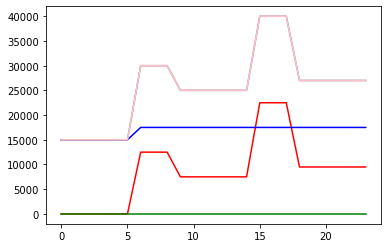

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PA=[]; PB=[]; PC=[]; PTOT=[]
NBA=[]; NBB=[]; NBC=[]



for j in range(len(Dem)):        
    PA.append(Puiss["A",j].x)
    PB.append(Puiss["B",j].x)
    PC.append(Puiss["C",j].x)
    PTOT.append(Puiss["A",j].x + Puiss["B",j].x + Puiss["C",j].x)
    
ar = [PA, PB, PC, PTOT]

df=pd.DataFrame(data=ar, index=["A", "B", "C", "TOT"])

plt.plot(df.loc["A"],'r')
plt.plot(df.loc["B"],'b')
plt.plot(df.loc["C"],'g')
plt.plot(Dem,'grey')
plt.plot(df.loc["TOT"],'pink')



plt.show()

In [56]:
for i in CENTRALE:
    for j in range(len(Dem)):
        print(CSTR1[i,j].pi)

AttributeError: 'gurobipy.Constr' object has no attribute 'pi'

In [ ]:
Dem=[15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]
for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
CENTRALE, nb, Pmin, Pmax, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 1.5],
    'B' : [10, 1250, 1750, 1.38],
    'C' : [5, 1500, 4000, 2.750],
})

model = gp.Model(name = 'Centrales thermiques')

S = {(i,j) : model.addVar(vtype=gp.GRB.CONTINUOUS,
                                  lb=0)                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : model.addVar(vtype=gp.GRB.CONTINUOUS, lb=0)
                for i in CENTRALE for j in range(len(Dem))}

#DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
#            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = { i : nb[i]*Pmax[i] 
            for i in CENTRALE}

#CSTR1 = { (i,j) : model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
#         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : model.addLConstr(DISPOMAX[i], "=" ,Puiss[i,j] + S[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

#CSTR4 =  { (i,j) : model.addLConstr(NBcentrale[i,j],"<=",nb[i])
#         for i in CENTRALE for j in range(len(Dem))}

model.setObjective(sum(Puiss[i,j]*Cmwh[i] for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

model.update()

model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 96 rows, 144 columns and 216 nonzeros
Model fingerprint: 0xb4de1ac7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+04]
Presolve removed 81 rows and 99 columns
Presolve time: 0.01s
Presolved: 15 rows, 45 columns, 45 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.5266000e+05   1.743750e+04   0.000000e+00      0s
      15    8.6940000e+05   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.02 seconds (0.00 work units)
Optimal objective  8.694000000e+05


In [ ]:
Dem=[15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]
for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
CENTRALE, nb, Pmin, Pmax, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 1.5],
    'B' : [10, 1250, 1750, 1.38],
    'C' : [5, 1500, 4000, 2.750],
})

model = gp.Model(name = 'Centrales thermiques')

S = {(i,j) : model.addVar(vtype=gp.GRB.CONTINUOUS,
                                  lb=0)                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : model.addVar(vtype=gp.GRB.CONTINUOUS, lb=0)
                for i in CENTRALE for j in range(len(Dem))}

#DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
#            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = { i : nb[i]*Pmax[i] 
            for i in CENTRALE}

#CSTR1 = { (i,j) : model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
#         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : model.addLConstr(DISPOMAX[i], "=" ,Puiss[i,j] + S[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

#CSTR4 =  { (i,j) : model.addLConstr(NBcentrale[i,j],"<=",nb[i])
#         for i in CENTRALE for j in range(len(Dem))}

model.setObjective(sum(Puiss[i,j]*Cmwh[i] for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

model.update()

model.optimize()